<a href="https://colab.research.google.com/github/dunkel000/Adv_Fin_ML_Exercises/blob/master/Estimation_of_price_impact_kernel_pessimistic_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## **Price Impact Estimation Algorithm**




*   Price impact refers to the empirical fact that execution of a large order affects the risky asset's price in an adverse and persistent manner and is leading to less favourable prices for the trader.
*   Propagator models serve as a central tool in quantifying price impact
 mathematically.

* Propagator models assume that there exists a matrix $G = (G_{i,j})$, known as the propagator
or the price impact kernel, such that the asset's execution price $S$ is given by



 \begin{equation}  
   S_{t_{i+1}} =  S_{t_1} + \sum_{j =1}^{i} G_{i,j}  u_{t_j}
+A_{t_i}+  \varepsilon_{t_i} ,
\quad i=1,\ldots, M, \quad (1)
\end{equation}
*  where the process $A+\varepsilon$ represents the fundamental (or unaffected) asset price. Here $A$ is often referred to as a trading signal and $\varepsilon$ is a mean-zero noise process.
* The propagator $G_{i,j}$ typically decays for $j \gg i$ and hence the sum is often referred to as transient price impact.

* The trader can only observe the visible price process $ S$, her own trades $  u$ and the trading signal $ A$.
* In order to quantify the price impact and to design a profitable trading strategy, the trader needs a precise estimation of the matrix $
 G$.

* In this notebook we have a two step procedure: \\
 (i) Introducing an offline estimator $\hat G$ to the propagator $G$ (see Sections 1-3), \\
 (ii) using the estimator $\hat G$ in order to improve the P&L of a greedy trading strategies $\hat u$ based on $\hat G$ (in Sections 4-5).



In [ ]:
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
from scipy.linalg import toeplitz
import random


 # **1. Synthetic Dataset**
* We follow the dataset construction from Section 3 of https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4564225
* We create a synthetic dataset of trades and prices build out of TWAP strategies, executions strategies following Obizhaeva and Wang's model, and strategies that are following an OU signal.
* Note that the market participants in the database are not aware of the true propagator.

**Step1**: We simulate the OU-process $(I_t)_{t \in [0,T]}$ and the signal  $$A_{t_i}= \int_{0}^{t_i} I_s \mathrm{d}s,$$ on a given time-grid $\lbrace 0 =  t_1 < t_2 < \ldots < t_M = T \rbrace $.

In [ ]:
def OU_process(gamma,sigma,M,N,T,I0):

    I = np.zeros((M,N))
    signal = np.zeros((M,N))
    I[0,:] = I0
    signal[0,:] = I0
    h  = T/(M-1)
    sum = I0

    np.random.seed(43)
    rand_samples = np.random.randn(N)

    for i in range(M-1):

        I[i+1,:] = I[i,:] - gamma*h*I[i,:] + sigma*np.sqrt(h)*rand_samples
        sum += I[i+1,:]*h
        signal[i+1,:] = sum

    return I, signal

**Step 2**: For a given kernel $G$ we compute the execution strategy $u$ of an order of size $x_0$, that minimizes the price impact costs $C(u)= \sum_{i=1}^N \sum_{j=1}^M G_{i,j} u_iu_j$
 with fuel constraint on the initial inventory $x_0$. If $X=(X_{t_1},...,X_{t_m})$ is the inventory of the agent, hence $X_{t_{j}} = \sum_{i\leq j} u_i$ and the optimal inventory is given by:

   $$ X= \frac{x_0}{\boldsymbol{1}^{\top}(G+G^{\top})^{-1}\boldsymbol{1}} (G+G^{\top})^{-1} \boldsymbol{1}.$$

   Here $G^{\top}$ is the transpose of the matrix $G$

In [ ]:
def optimal_policy_no_signal(x_0,G):

  G_sym_inv = np.linalg.inv(G+G.T)
  M = np.size(G_sym_inv, 0)
  vec_ones = np.ones(M)

  g = np.matmul(G_sym_inv,vec_ones.T)
  g_tmp = np.dot(vec_ones,g)
  u = x_0 * g / g_tmp

  return u

**Step 3**: We construct the dataset of trades with $n=1,...,N$ trading days, where each day contains: time-weighted average price (TWAP) strategies,
realisations of from TWAP strategies $u^{(1,n)}$ (see u_cont_1[:,nn]), execution strategies given in Step 2 $u^{(2.n)}$ (see  u_cont_2[:,nn]) and signal following strategies $u^{(3,n)}$ (see u_cont_3[:,nn]).

 The output for each trading day is the aggregated order flow $u_{t_j}^{(n)}= \sum_{i=1}^3u^{(i,n)}_{t_j}$, $j=1,...,M$.



In [ ]:
def construct_dataset_cov(kappa,rho,beta,eta,MM,TT,NN,a,b,signal,lam):

    hh = TT/(MM-1)

    mat_cov = np.zeros((MM,MM))
    mat_cov_conv = np.zeros((MM,MM))

    array_tmp = np.arange(MM)
    array_tmp_rev = np.flip(array_tmp.copy())

    u_cont_1 = np.zeros((MM,NN))
    u_cont_2 = np.zeros((MM,NN))
    u_cont_3 = np.zeros((MM,NN))
    u_cont = np.zeros((MM,NN))

    np.random.seed(43)
    uniform_matrix = np.random.rand(5,NN)

    for nn in range(NN):

       x0 = a+ uniform_matrix[0,nn]*(b-a)
       G_tri = np.zeros((MM,MM))

       beta_rand =beta/2 +uniform_matrix[1,nn]*beta
       kappa_rand =kappa/2 +uniform_matrix[2,nn]*kappa
       rho_rand =rho/2 +uniform_matrix[3,nn]*rho
       eta_rand =eta/2 +uniform_matrix[4,nn]*eta

       for i_itr in range(MM):
            for jj in range(i_itr+1):
                G_tri[i_itr,jj] = kappa_rand*np.exp(-rho_rand*(i_itr-jj)*hh)

       u_cont_1[:,nn] = x0/MM
       u_cont_2[:,nn] = optimal_policy_no_signal(x0,G_tri)
       u_cont_3[:,nn] = (1-np.exp(-beta_rand*array_tmp_rev*hh))*signal[:,nn]/(2*beta_rand*eta_rand)

       u_cont[:,nn] = u_cont_1[:,nn] + u_cont_2[:,nn] + u_cont_3[:,nn]

       mat_cov += np.outer(u_cont[:,nn],u_cont[:,nn])
       toep_mat = np.tril(toeplitz(u_cont[:,nn]))

       mat_cov_conv += (toep_mat.T) @ toep_mat

    return mat_cov + lam*np.eye(MM), mat_cov_conv + lam*np.eye(MM), u_cont

**Step 4**: We generate a noise matrix $(\varepsilon^{(n)}_{t_j})$,  $j=1,...,M$, $n=1,...,N$.


In [ ]:
def noiseN(N,M,sigma,TT):

    np.random.seed(43)
    noise_pro =np.random.normal(0, 1, (M, N))*sigma*np.sqrt(TT/(M-1))

    return noise_pro

**Step 5**: Given the true kernel $G^{\star}$ and the trades $u^{(n)}$ from step 4, we compute the resulting price trajectories according to (1). We get,
$$
y_{t_i}^{(n)} = S^{(n)}_{t_i}-S_{t_1}^{(n)} -A_{t_i}^{(n)}= \sum_{j=1}^{i} G^\star_{i,j} u^{(n)}_{t_i} + ɛ^{(n)}_{t_i}.
$$  

In [ ]:
def yn(G_star,uN,noiseN,N,M):

    yN = np.zeros((M,N))

    for i in range(N):
      yN[:,i]= np.matmul(G_star,uN[:,i])+ noiseN[:,i]*np.sqrt(np.arange(0,M))

    return yN

We have obtained a dataset of $N$ days where each day $n=1,...,N$ we have $(S^{(n)},u^{(n)}, A^{(n)})$ a data series of intraday prices and trades.  

#  **2. Kernel Estimation**
* We describe our method for kernel estimation using the synthetic dataset developed in the previous steps.

* We follow the procedure from Section 2.2 of https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4564225

* We assume that our kernel is of convolution type, that is
$$
G_{i,j}=K_{i-j}, \quad \textrm{for }
  i \geq j.
$$
Examples for such kernels:
* $ K(t)=\frac{\ell_{_{0}}}{(\ell_{0}+t)^{\beta}}$, for some constants $\beta, \ell_0>0$, proposed by Bouchaud et al. in 2004.
* The example of $K(t)=\frac{1}{t^{\beta}}1_{\{t>0\}}$ for  $0< \beta < 1/2,$ were proposed by Gatheral in 2010.  
* The case where $K (t) =  e^{-\rho t}$, for some constant $\rho >0$, was proposed by Obizhaeva and Wang in 2005.  


## 2.1 The Estimator

* We assume that we have a dataset $$\mathcal{D} =  \{(S^{(n)}_{t_i})_{i=1}^{M+1}, (u^{(n)}_{t_i})_{i=1}^{M}, (A^{(n)}_{t_i})_{i=1}^{M}
\mid     n=  1, \ldots, N\},$$
where $(S^{(n)}_{t_i})_{i=1}^{M+1}$ is a price trajectory, $(u^{(n)}_{t_i})_{i=1}^{M}$ are child orders and $(A^{(n)}_{t_i})_{i=1}^{M}$ is a trajectory of the signal, all over one trading day.

* The convolution structure simplifies the connection between the dataset components (see eq. (1) above). For $n=1,\ldots, N$,
\begin{align}
S^{(n)}_{t_{i+1}}-S^{(n)}_{t_1}-A^{(n)}_{t_i}
&  
= \sum_{j=0}^{i-1} K^\star_{j } u^{(n)}_{t_{i-j}} +\varepsilon^{(n)}_{t_i},
\quad  i=1,\ldots, M,
\end{align}

* We recall that $\varepsilon^{(n)}_{t_i}$ is a noise term.

* This can be written in a matrix form: $y^{(n)} =U_n K^\star +\varepsilon^{(n)} $, with
$$
    y^{(n)} =
\begin{pmatrix}
S^{(n)}_{t_{2}}-S^{(n)}_{t_1}-A^{(n)}_{t_1}
\\
\vdots
\\
S^{(n)}_{t_{M+1}}-S^{(n)}_{t_1}-A^{(n)}_{t_M}
\end{pmatrix},
\;
U_n = \begin{pmatrix}
     u^{(n)}_{t_1} & 0 & \cdots & 0\\
    u^{(n)}_{t_2} & u^{(n)}_{t_1} & \cdots & 0\\
     \vdots & \vdots & \ddots & \vdots\\
     u^{(n)}_{t_M} & u^{(n)}_{t_{M-1}} & \cdots  &  u^{(n)}_{t_1}
 \end{pmatrix},
 \; \\
 \varepsilon^{(n)} =
\begin{pmatrix}
\varepsilon^{(n)}_{t_1}
\\
\vdots
\\
\varepsilon^{(n)}_{t_M}
\end{pmatrix}. \\
$$
* We define the following matrix
$$
W_{N,\lambda}= \sum_{n=1}^N U^\top_n U_n  +\lambda \mathbb{I}_{M },
$$
where $\lambda>0$ is a small constant that we choose so that $W_{N,\lambda}$ is invertible.

*  The estimator for $K = (K_0,...,K_{M-1})^\top$ is a solution to a least square problem

$$
   \tilde{K}_{N,\lambda}
=\textrm{argmin}_{K \in  \mathbb{R}^M}\left\| W_{N,\lambda}^
{\frac{1}{2}}\left(K-\tilde{K}_{N,\lambda}\right)\right\|^2.
$$

* It is given by $$\tilde{K}_{N,\lambda} = (W_{N,\lambda})^{-1} \sum_{n=1}^{N} (U^{(n)})^{\top}  y^{(n)}.$$ See eq. (2.27) on page 12 of https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4564225

* In the following function we implement the estimator $\tilde{K}_{N,\lambda}$.


In [ ]:
def non_proj_conv(WNlamb,uN,yN,N,M):

    WNlamb_inv = np.linalg.inv(WNlamb)

    K_est = np.zeros(M)

    for i in range(N):
       toep_mat = np.tril(toeplitz(uN[:,i]))
       K_est +=  (toep_mat.T) @ yN[:,i]

    return  WNlamb_inv @ K_est

## 2.2 Projection of the Estimator

* We recall that our primary examples the beginning of this section were a power law kernel and an exponentially decaying kernel. Both examples and many others are convex and decreasing kernels.  

* In order to make our estimator more precise we project the estimator $\tilde{K}_{N,\lambda}$ onto the space of admissible kernels  
$$
\begin{aligned}
\mathscr{K}_{\textrm{ad}} =  
\{
K=(K_{i})_{i=0}^{M-1}
\,|&  
  K_i-K_{i-1} \leq K_{i+1}-K_{i} \leq 0 \\
  & \textrm{ for all } 1\leq i \leq M-2\}.
  \end{aligned}
$$
* We call the projected kernel ${K}_{N,\lambda}$ and we also make sure that it is positive definite.  
* The implementation of the projection is given below.

In [ ]:
def proj_conv(M,A,B,mu):

    X = cp.Variable((M,M)) # create variable
    objective = cp.Minimize(cp.sum_squares(B @ (X[:,0] - A)))

    constraints = [cp.upper_tri(X)  == 0,  X + X.T - mu*np.eye(M) >> 0]

    for i in range(M-1):
        constraints.append(X[i:(M-1),i] == X[(i+1):M,i+1])

    M_decrease = np.eye(M)-np.eye(M, k=1)
    constraints.append( (M_decrease @ X[:,0]) >= 0) # decreasing + non-negative  condition

    M_convex = (-2)* np.eye(M) + np.eye(M, k=1) + np.eye(M, k=-1)
    constraints.append( (M_convex[1:(M-1),:] @ X[:,0]) >= 0) # convexity condition


    # define and solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve(eps=1e-12)

    return X.value

In [ ]:
def proj_conv_bad(M,A,B,mu):

    X = cp.Variable((M,M)) # create variable
    objective = cp.Minimize(cp.sum_squares(B @ (X[:,0] - A)))

    constraints = [cp.upper_tri(X)  == 0,  X + X.T - mu*np.eye(M) >> 0]

    for i in range(M-1):
        constraints.append(X[i:(M-1),i] == X[(i+1):M,i+1])

    # define and solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve(eps=1e-12)

    return X.value

# **3. Examples of Price Impact Kernel Estimations**

We demonstrate the performance of the estimator from Section 2 based on the dataset created in Section 1.  

##  3.1 Example: Truncated Power Law Kernel

* We consider the truncated power law kernel $ K(t)=\frac{\ell_{_{0}}}{(\ell_{0}+t)^{\beta}}$, for some constants $\beta, \ell_0>0$.

* The non-parametric estimator $\tilde{K}_{N,\lambda}$ (before projection) from Section 2.1 is implemented below.

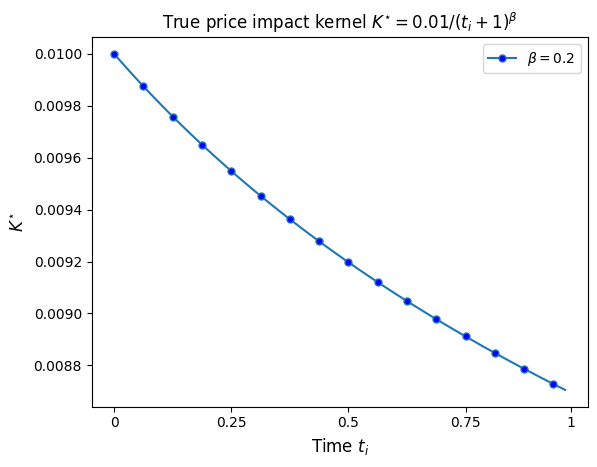

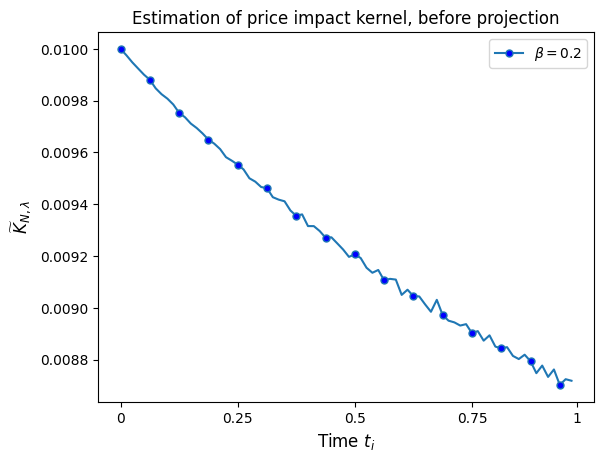

In [ ]:
MM = 78
NN = 252
TT = 1
beta_ou = 0.1

II, signalA = OU_process(beta_ou,0.06,MM,NN,TT,0)

kappa = 0.01
rho= 0.04
eta = kappa
a = 500
b = 2000

cov_reg, cov_reg_conv, controls = construct_dataset_cov(kappa,rho,beta_ou,eta,MM,TT,NN,a,b,signalA,1e-03)

sigma_noise = 0.0088
noise_pro = noiseN(NN,MM,sigma_noise,TT)
hh = TT/(MM-1)


beta = 0.2
G_star = np.zeros((MM,MM))
for i_itr in range(MM):
    for jj in range(i_itr+1):
        G_star[i_itr,jj] = kappa/(((i_itr-jj)*hh +1)**beta)

yN = yn(G_star,controls,noise_pro,NN,MM)
K_est = non_proj_conv(cov_reg_conv,controls,yN,NN,MM)

V,_ = np.linalg.eig(G_star.copy()+(G_star.copy()).T)
mu = np.min(np.real(V))

DD, VV = np.linalg.eigh(cov_reg_conv)
diag_mat = np.diag(np.sqrt(DD))
B = (VV @ diag_mat ) @ VV.T


plt.plot(G_star[:,0],marker='o', markerfacecolor='blue',markevery=5,markersize=5,label=r"$\beta  = %.1f$" %beta)
plt.xlabel("Time $t_i$",fontsize=12)
plt.ylabel("$K^{\star}$",fontsize=12)

positions = (0, 20, 40, 60, 78)
labels = ("0","0.25", "0.5", "0.75", "1")
plt.xticks(positions, labels)

plt.title('True price impact kernel $K^{\star}=0.01/(t_i +1)^{\\beta}$')

plt.legend()
plt.show()

plt.plot(K_est,marker='o', markerfacecolor='blue',markevery=5,markersize=5,label=r"$\beta  = %.1f$" %beta)
plt.xlabel("Time $t_i$",fontsize=12)
plt.ylabel(r'$\widetilde K_{N,\lambda}$',fontsize=12)

positions = (0, 20, 40, 60, 78)
labels = ("0","0.25", "0.5", "0.75", "1")
plt.xticks(positions, labels)

plt.title('Estimation of price impact kernel, before projection')

plt.legend()
plt.show()

* We now refine the result using the projected estimator $\tilde{K}_{N,\lambda}$ from Section 2.2.

/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


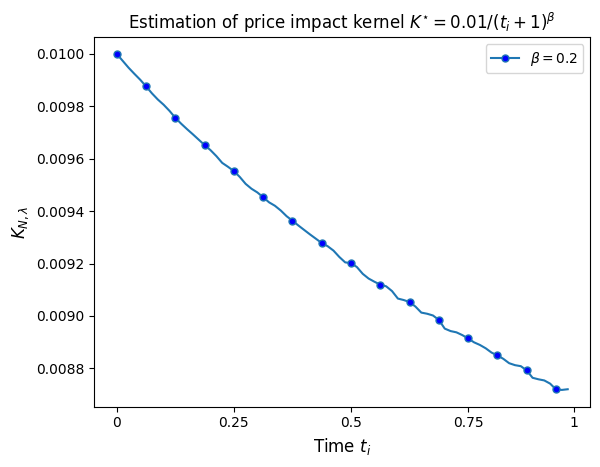

In [ ]:
K_est_proj = proj_conv(MM,K_est,B,mu)

plt.plot(K_est_proj[:,0],marker='o', markerfacecolor='blue',markevery=5,markersize=5,label=r"$\beta  = %.1f$" %beta)
plt.xlabel("Time $t_i$",fontsize=12)
plt.ylabel("$K_{N,\lambda}$",fontsize=12)

positions = (0, 20, 40, 60,78)
labels = ("0","0.25", "0.5", "0.75", "1")
plt.xticks(positions, labels)

plt.title('Estimation of price impact kernel $K^{\star}=0.01/(t_i +1)^{\\beta}$')
plt.legend()
plt.show()

* In order to quantify the accuracy of our estimators and to demonstrate the importance of the projection step,
* We denote by $K^\star$ the true kernel.
* We define the following relative errors for different sample sizes $N$:
$$ \text{err} := \max_{j \in \lbrace 1, \ldots, M \rbrace} \frac{|(K^{\star})_j - (\tilde{K}_{N,\lambda})_j|}{(K^{\star})_j},
\quad
\text{err}_{\textrm{proj}} := \max_{j \in \lbrace 1, \ldots, M \rbrace} \frac{|(K^{\star})_j - (K_{N,\lambda})_j|}{(K^{\star})_j}.
$$
* Here $K^{\star}$ refers to the power-law kernel with
 $\beta^{\star} = 0.2$,   
* $\tilde{K}_{N,\lambda}$ is the estimated kernel using the plain least-squares estimator, and
 ${K}_{N,\lambda}$ is obtained by an additional projection step.
* We find that the relative error is of order $0.001$!

In [ ]:
#Compute max relative error

#Power law kernel

#before projection
print(np.max(np.abs(G_star[:,0]-K_est)/G_star[:,0]))

#after projection
print(np.max(np.abs(G_star[:,0]-K_est_proj[:,0])/G_star[:,0]))


0.004397966494754243
0.0016963899476880543


##  3.2 Example: Exponential Kernel

* We consider the exponential kernel $K (t) =  e^{-\rho t}$, for some constant $\rho >0$

* The non-parametric estimator $\tilde{K}_{N,\lambda}$ (before projection) from Section 2.1 is implemented below.

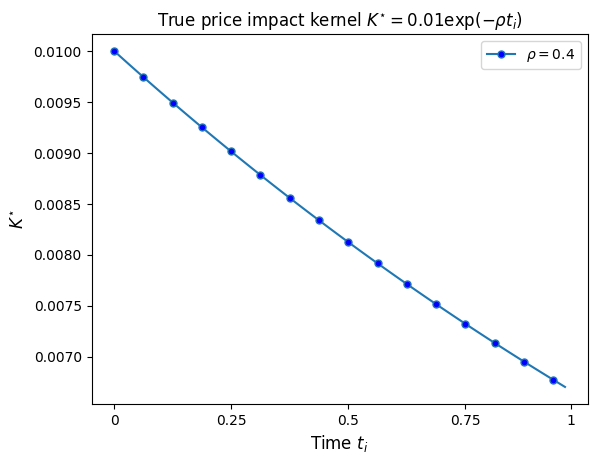

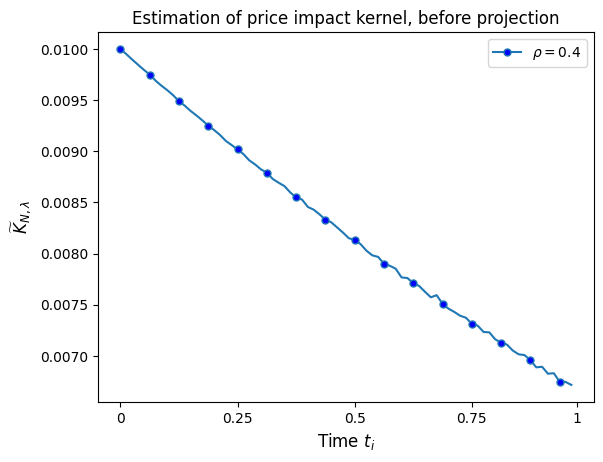

In [ ]:
rho = 0.4
G_star_exp = np.zeros((MM,MM))
for i_itr in range(MM):
    for jj in range(i_itr+1):
        G_star_exp[i_itr,jj] = 0.01*np.exp(-rho*(i_itr-jj)*hh)

yN = yn(G_star_exp,controls,noise_pro,NN,MM)
K_est_exp = non_proj_conv(cov_reg_conv,controls,yN,NN,MM)

V_exp,_ = np.linalg.eig(G_star_exp.copy()+(G_star_exp.copy()).T)
mu_exp = np.min(np.real(V_exp))


plt.plot(G_star_exp[:,0],marker='o', markerfacecolor='blue',markevery=5,markersize=5,label=r"$\rho  = %.1f$" %rho)
plt.xlabel("Time $t_i$",fontsize=12)
plt.ylabel("$K^{\star}$",fontsize=12)

positions = (0, 20, 40, 60, 78)
labels = ("0","0.25", "0.5", "0.75", "1")
plt.xticks(positions, labels)

plt.title('True price impact kernel $K^{\star}=0.01 \exp(-\\rho t_i)$')

plt.legend()
plt.show()

plt.plot(K_est_exp,marker='o', markerfacecolor='blue',markevery=5,markersize=5,label=r"$\rho  = %.1f$" %rho)
plt.xlabel("Time $t_i$",fontsize=12)
plt.ylabel(r'$\widetilde K_{N,\lambda}$',fontsize=12)

positions = (0, 20, 40, 60, 78)
labels = ("0","0.25", "0.5", "0.75", "1")
plt.xticks(positions, labels)

plt.title('Estimation of price impact kernel, before projection')

plt.legend()
plt.show()

* We now refine the result using the projected estimator $\tilde{K}_{N,\lambda}$ from Section 2.2.

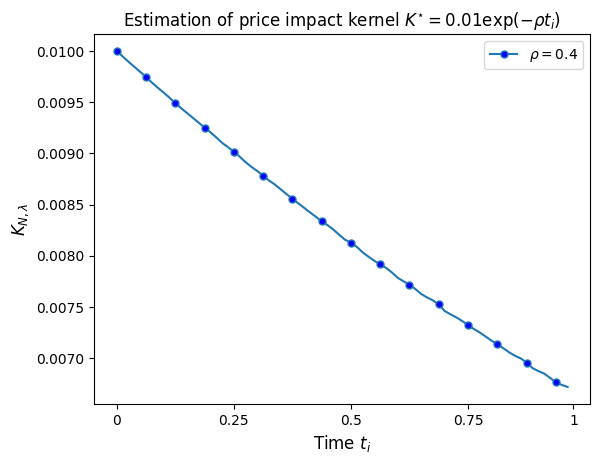

In [ ]:
K_est_proj_exp = proj_conv(MM,K_est_exp,B,mu_exp)

plt.plot(K_est_proj_exp[:,0],marker='o', markerfacecolor='blue',markevery=5,markersize=5,label=r"$\rho  = %.1f$" %rho)
plt.xlabel("Time $t_i$",fontsize=12)
plt.ylabel("$K_{N,\lambda}$",fontsize=12)

positions = (0, 20, 40, 60,78)
labels = ("0","0.25", "0.5", "0.75", "1")
plt.xticks(positions, labels)

plt.title('Estimation of price impact kernel $K^{\star}=0.01 \exp(-\\rho t_i)$')
plt.legend()
plt.show()

* In order to quantify the accuracy of our estimators and to demonstrate the importance of the projection step,
* We denote by $K^\star$ the true kernel which is exponential kernel with $\rho^{\star} = 0.4$,
* We define the following relative errors for different sample sizes $N$:
$$ \text{err} := \max_{j \in \lbrace 1, \ldots, M \rbrace} \frac{|(K^{\star})_j - (\tilde{K}_{N,\lambda})_j|}{(K^{\star})_j},
\quad
\text{err}_{\textrm{proj}} := \max_{j \in \lbrace 1, \ldots, M \rbrace} \frac{|(K^{\star})_j - (K_{N,\lambda})_j|}{(K^{\star})_j}.
$$
* $\tilde{K}_{N,\lambda}$ is the estimated kernel using the plain least-squares estimator, and
 ${K}_{N,\lambda}$ is obtained by an additional projection step.
* We find that the relative error is of order $0.001$!



In [ ]:
#Compute max relative error

#Exponential kernel

#before projection
print(np.max(np.abs(G_star_exp[:,0]-K_est_exp)/G_star_exp[:,0]))

#after projection
print(np.max(np.abs(G_star_exp[:,0]-K_est_proj_exp[:,0])/G_star_exp[:,0]))

0.005235086536246773
0.0023979338518918722


# **4. Pessimistic Approach to Offline Learning in Trade Execution**

* In this notebook we have a two step procedure:
 (i) offline estimation of the propagator $G$ (see Sections 1-3)
 (ii) using the estimator $\hat G$  in order to obtain a greedy strategy $\hat u$ (in Sections 4-5).
* We will explain why using the estimator $\hat G$ in order to obtain a greedy strategy $\hat u$ may cause some excessive trading costs.  
* Recall that the expected costs of a trade of size $x_0$ executed within the time interval $[0,T]$   (Gatheral et al ('12), Lehalle-N. ('19) ):  
 \begin{equation*}  
\begin{aligned}
%\label{per-func}
J(u;G)
&=  \mathbb{E}\left[  {\sum_{i=1}^{M}  \sum_{j=1 }^{i} G_{i,j}  u    _{t_j} u_{t_i}}
+ { \sum_{i=1}^M A_{t_i} u_{t_i}}  \right],
\end{aligned}
\end{equation*}  
* where the trading "speed" $u=(u_{t_i})_{i=1}^M$ is signal-adapted and satisfies a fuel constraint  i.e., $\sum_{i=1}^N u_{t_i} = x_0$.
* The **first term** in the expectation represents the price impact costs and the **second term** represents the fundamental price of the trade.  
* The **greedy strategy** $\hat u$ is defined as the minimiser of the trading costs $J(u,\hat G)$ when we plug $\hat G$ in the estimator from Section 3.  
* We propose a stochastic control framework that will **eliminate the correlation** between a greedy trading strategy $\hat u$ and the estimated price impact kernel $\hat G$ calculated in Section 3.
* We will show that this correlation may create **excessive trading costs**, which we would like to prevent.   


## **4.1 The chalanges in Offline reinforcement learning in trade execution**

 * We explain why using the estimator $\hat G$ in order to obtain a greedy strategy $\hat u$ may cause some excessive trading costs.  
 *We denote by $( G^{\star}, u^{\star},J)$ the true propagator, the optimal strategy and the associated cost functional $J$, respectively.
 * We use the notation $(\hat G, \hat u^{\hat G}, \hat J)$ for the estimator of the true kernel $G^\star$, a convex cost functional $\hat J(\cdot;\hat G)$  using $\hat G$, and a greedy strategy $\hat u^{\hat G}$ minimising this functional.
 * Note that we do not insist that $\hat J$ and $J$ necessarily agree, that is we allow $ \hat J(\cdot,  G) \not=  J(\cdot,  G)$ for some or all $G$'s.  


 ## **4.2 Suboptimality in offline reinforcement learning in trade execution**
* The suboptimality of an arbitrary algorithm that aims to estimate $G^{\star}$ and also produces a greedy
strategy $\hat u$ is defined as follows:
$$
 \textrm{SubOpt} = J(\hat u^{{\hat G}}; G^{\star}) - J( u^{\star}; G^{\star}).
$$
* We decompose the suboptimality in the following way:
$$
\begin{aligned}
\textrm{SubOpt} &=\underbrace{J(\hat u^{{\hat G}}; G^{\star}) - \hat J( \hat u^{\hat G} ; {\hat G})}_\text{(i): Spurious Correlation} + \underbrace{\hat J( u^{\star}; {\hat G}) - J( u^{\star}; G^{\star})}_\text{(ii): Intrinsic Uncertainty}  \\
&+\underbrace{\hat J(  \hat u^{{\hat G}} ;{ \hat G}) -\hat J(  u^\star ;  {\hat G})}_\text{(iii): Optimization Error}.
\end{aligned}
$$
* Term (i) is the most challenging to control, as $ \hat u^{{\hat G}}$, ${\hat G}$ and hence $\hat J (\cdot, {\hat G})$ simultaneously depend on the dataset $\mathcal{D}$. This leads to a spurious correlation between them.
* Term (ii) is less challenging to control, as $u^\star$ is the minimiser of $J(\cdot;  G^{\star})$, hence it does not depend on $\mathcal D$ and in particular on $\hat J(\cdot; { \hat G})$.
*Finally we notice that the optimization error in term (iii) is nonpositive as long as $\hat u^{ {\hat G}}$ is greedy (i.e., optimal) with respect to $\hat J(\cdot; {\hat G})$.


## **4.3 Taming the components of the suboptimality**

* We take $G$ as the true propagator and use the estimator $ \hat G$ from Section 3.

* Recall that in Section 3 we defined the offline (historical) dataset $$\mathcal{D} =  \{(S^{(n)}_{t_i})_{i=1}^{M+1}, (u^{(n)}_{t_i})_{i=1}^{M}, (A^{(n)}_{t_i})_{i=1}^{M}
\mid     n=  1, \ldots, N\},$$
where $(S^{(n)}_{t_i})_{i=1}^{M+1}$ is a price trajectory, $(u^{(n)}_{t_i})_{i=1}^{M}$ are child orders and $(A^{(n)}_{t_i})_{i=1}^{M}$ is a trajectory of the signal, all over one trading day.


* We further define the covariance matrix of the trades, $ V_{N,\lambda}$ which is based on the trades in the data set:
$$
 V_{N,\lambda}=\sum_{n=1}^N u^{(n)} (u^{(n)})^{\top } +\lambda \mathbb{I}_{M }.
$$
Here $\lambda>0$ is a regularization constant chosen to be small. It ensures invertibility of $V_{N,\lambda}$.
* Recall that we have defined the cost functional  $J$ at the begining of Section 4. We propose a new cost functional of the form:
  $$
\hat J (u ;{\hat G}) =  J (u ; {\hat G}) + C\mathbb{E} \left [  \big\| V_{N,\lambda}^{-\frac{1}{2}} u  \big\|\right], \quad   u \in \mathcal A,
$$
with $C>0$ a regularization constant to be chosen and $\|\cdot\|$ is the Euclidean norm.
* The new term in $\hat J (u ;{\hat G})$ penalises trading strategies visiting states or using actions, which were not explored in the historical dataset (see Example A.2 in https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4564225).  



* We denote by $\hat u^{{\hat G}}$ the minimizer of the new cost functional $\hat J (\cdot;{\hat G})$.
* In the following demonstration we will show that the new strategy $\hat u^{{\hat G}}$ segnificantly outperforms the greedy strategy $ \hat u$ which mimizes the original cost functional $J (\cdot;{\hat G})$.
* More sepfically $\hat u^{{\hat G}}$ reduces the suboptimality to
$$
 \textrm{SubOpt} = J(\hat u^{{\hat G}}; G^{\star}) - J( u^{\star}; G^{\star}),
$$
i.e., eliminates the spurious correlation; which does not vanish if we use the greedy strategy $\hat u$.  
* Moreover in Theorem 2.23 of https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4564225, we show that $\hat u^{{\hat G}}$ eliminates the spurious correlation defined in Section 4.2 and that the suboptimlity is of order $1/\sqrt{N}$ where $N$ is the number of metaorders in the offline dataset.
* This theoretical result, which is valid for a well-explored dataset, gives an optimal rate of convergence regarding the dependence in $N$.

## **4.4 Implementation**
* In order to implement the methodology from Section 4.4 we first need to create a noisy estimation $\hat G$ to $G$.
* In order to do that we consider the true propgator to be the power law kernel $ G(t-s)=\frac{0.01}{(1+(t-s))^{0.4}}$.
* We create a synthetic dataset of trades, prices and signals which is similar to the one created in Section 1.  
* Since our estimation results for convolution kernels such as the power law were very accurate we try to fit now Volterra Kernel $G(t,s)$ to the power law kernel in order to create a noisy estimation.
* The space of Volterra Kernels is much larger as it contains two variable funtions $(t,s)$ instead of one in the convolution case.
* The estimation process for Volterra kernels follows the same lines as the covoluton case in Sections 2-3, and is described in detalis on Section 2 of https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4564225
* The scripts below are an implementation of this procedure.

In [ ]:
#Volterra estimation of price impact

def non_proj(VNlamb,uN,yN,N,M):

    VNlamb_inv = np.linalg.inv(VNlamb)

    G_est = np.zeros((M,M))

    for i in range(N):
       G_est +=  np.outer(yN[:,i],uN[:,i])

    return G_est @ VNlamb_inv

In [ ]:
#Projection of the Volterra estimator

def proj(M,A,B,mu):

    X = cp.Variable((M, M))
    objective = cp.Minimize(cp.sum_squares((X - A) @ B))
    constraints = [cp.upper_tri(X)  == 0,  X + X.T - mu *np.eye(M) >> 0]

    problem = cp.Problem(objective, constraints)
    problem.solve(eps=1e-5)

    return X.value

In [ ]:
#Creation of the data set step 1: solve optimization problem (2.34) in the paper with zero signal

def convex_optimizer_regularisation(M,G,const_val,covariance_inv,x0):

    x = cp.Variable(M)
    vec_ones = np.ones(M)
    G = (G.copy()).T + G.copy()

    prob_2 = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, G) + const_val*cp.norm(covariance_inv@x,2)),
                 [  x@vec_ones.T == x0])
    prob_2.solve(solver='SCS')

    return prob_2.value, x.value

In [ ]:
#Creation of the data set step 2: signal process

MM = 78
NN = 252
TT = 1
beta = 0.1
sigma = 0.06

#signal process
_, signalA = OU_process(beta,sigma,MM,NN,TT,0)

In [ ]:
#Creation of the data set step 3: construct dataset

kappa = 0.01
rho= 0.04
eta = kappa
a =  500
b =  2000
x0 = 1000
lambda_val = 1e-03

cov_reg, cov_reg_conv, controls = construct_dataset_cov(kappa,rho,beta,eta,MM,TT,NN,a,b,signalA,lambda_val)

In [ ]:
#Creation of the data set step 4: true propagator/model, noise pricess and simulated trajectories

hh = TT/(MM-1)
G_tri_2 =  np.zeros((MM,MM))
for i_itr in range(MM):
    for jj in range(i_itr+1):
        G_tri_2[i_itr,jj] = kappa/(((i_itr-jj)*hh +1)**0.4)

sigma_noise = 0.1
noise_pro = noiseN(NN,MM,sigma_noise,TT)
yN = yn(G_tri_2,controls,noise_pro,NN,MM)

In [ ]:
#Estimation of the price impact power law kernel from dataset in a Volterra form

G_est = non_proj(cov_reg,controls,yN,NN,MM)

#compute minial eigenvalue of true impact
V,_ = np.linalg.eig(G_tri_2.copy()+(G_tri_2.copy()).T)
mu = np.min(np.real(V))

#Compute square-root of V_{N,\lambda}
DD, VV = np.linalg.eigh(cov_reg)
diag_mat = np.diag(np.sqrt(DD))
B = (VV @ diag_mat ) @ VV.T

#projected price impact matrix
G_tri = proj(MM,G_est,B,mu)

### **Coputation of the new cost fuctional $\hat J (u ;{\hat G})$**
*Recall that we proposed a new cost functional of the form:
  $$
\hat J (u ;{\hat G}) =  J (u ; {\hat G}) + C(N)\mathbb{E} \left [  \big\| V_{N,\lambda}^{-\frac{1}{2}} u  \big\|\right], \quad   u \in \mathcal A,
$$
* In the following lines we first compute the constant $C(N)$ as in equations (2.31) and (2.32) in https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4564225
but in fact you could choose the value of C yourself, depending on the strength of penalisation that you want.
* The we compute
$$
 V_{N,\lambda}=\sum_{n=1}^N u^{(n)} (u^{(n)})^{\top } +\lambda \mathbb{I}_{M }.
$$
Here $\lambda>0$ is a regularization constant chosen to be small.  
* Recall that we have defined the cost functional  $J$ at the begining of Section 4.

In [ ]:
#compute constant in equation (2.31) and (2.32)

R = 1
delta = 0.01

info_gain_tmp = (np.linalg.det(cov_reg))
info_gain_tmp_2 = np.log(lambda_val)
info_gain = np.sqrt(MM*np.log(info_gain_tmp) -info_gain_tmp_2*MM**2 + np.log(delta**(-2)))

#upper bound for control and price impact
control_norm_upper_bound  = x0
G_upper_bound = np.linalg.norm(G_tri_2,ord='fro')

#computes V^{-1/2}_{N,\lambda}
V_root_inv =  (VV @ ( np.linalg.inv(diag_mat)) ) @ VV.T

#constant in equation (2.31)
const_val = control_norm_upper_bound*(R*info_gain + lambda_val*G_upper_bound*np.linalg.norm(V_root_inv ,ord='fro'))

### **Coputation of the strategies**
* Recall that $\hat G$ is the estimator for the true propgator $G$.
* We compute the trading speed, inventory and P&L of the following stratgies: \\
 1. The greedy strategy $\hat u$ which minimise $J(\cdot, \hat G)$.
 2. Our proposed pessimisitc strategy $\hat u^{\hat G}$ which minimise $\hat J(\cdot, \hat G)$.
 3. The optimal strategy $u^*$ which minimise $J(\cdot,G)$.



In [ ]:
#compute greedy strategy
greedy_policy = optimal_policy_no_signal(x0,G_tri)

#compute pessimistic strategy
_, pessimistic_policy =  convex_optimizer_regularisation(MM,G_tri,const_val,V_root_inv,x0)

#compute analytic strategy
policy_analytic = optimal_policy_no_signal(x0,G_tri_2)

In [ ]:
#compute inventory profile for the three different strategies

inventory_analytic_t = x0 - np.cumsum(policy_analytic)
inventory_analytic = np.insert(inventory_analytic_t,0,x0)

inventory_greedy_t = x0 - np.cumsum(greedy_policy)
inventory_greedy  = np.insert(inventory_greedy_t,0,x0)

inventory_pessimistic_t = x0 - np.cumsum(pessimistic_policy)
inventory_pessimistic = np.insert(inventory_pessimistic_t,0,x0)

In [ ]:
#compute value functions for different policies using the true model

g = np.matmul(G_tri_2,policy_analytic.T)
true_val_fun = np.dot(g,policy_analytic)

g_reg = np.matmul(G_tri_2,pessimistic_policy)
val_fun_reg = np.dot(g_reg,pessimistic_policy)

g_greedy = np.matmul(G_tri_2,greedy_policy)
val_fun_greedy= np.dot(g_greedy,greedy_policy)

### **Comparision of the strategies**
* In the following plots we compare the trading speed, inventory and P&L of the following stratgies: \\
 1. The greedy strategy $\hat u$ which minimise $J(\cdot, \hat G)$.
 2. Our proposed pessimisitc strategy $\hat u^{\hat G}$ which minimise $\hat J(\cdot, \hat G)$.
 3. The optimal strategy $u^*$ which minimise $J(\cdot,G)$.

* We find that the greedy strategy $\hat u$ is very noisy due to the correlation with the noisy estimation of $\hat G$. The pessimisitc strategy $\hat u^{\hat G}$ is much closer to the strategy $u^*$.

* Comparison of the P&L shows a major improvment of the pessimistic strategy of the greedy one:

**P&L optimal**: 4500.241081344141 \\
**P&L pessimistic**: 4537.289205113061 \\
**P&L greedy**: 6104.436234904243




4500.241081344141
4537.289205113061
6104.436234904243


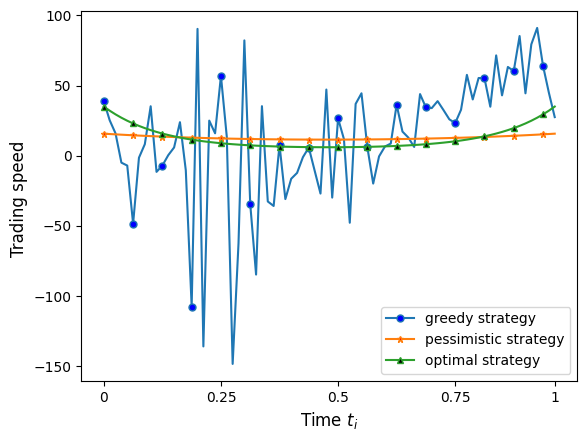

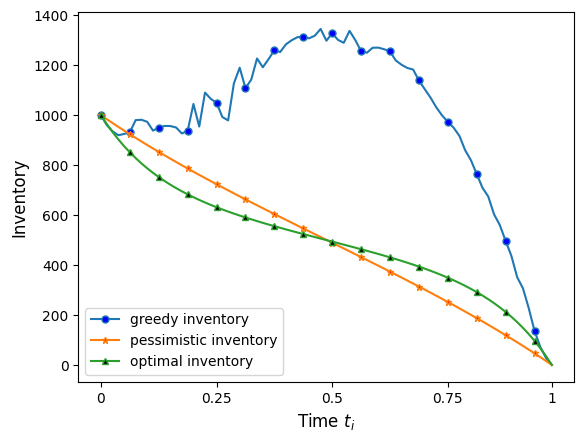

In [ ]:
#plot results

print(true_val_fun)
print(val_fun_reg)
print(val_fun_greedy)

plt.plot(greedy_policy,marker='o', markerfacecolor='blue',markevery=5,markersize=5,label="greedy strategy")
plt.plot(pessimistic_policy,marker='*', markerfacecolor='red',markevery=5,markersize=5,label="pessimistic strategy")
plt.plot(policy_analytic,marker='^', markerfacecolor='black',markevery=5,markersize=5,label="optimal strategy")

plt.xlabel("Time $t_i$",fontsize=12)
plt.ylabel("Trading speed ",fontsize=12)
positions = (0, 20, 40, 60, 77)
labels = ("0","0.25", "0.5", "0.75", "1")
plt.xticks(positions, labels)
plt.legend()
plt.show()

plt.plot(inventory_greedy,marker='o', markerfacecolor='blue',markevery=5,markersize=5,label="greedy inventory")
plt.plot(inventory_pessimistic,marker='*', markerfacecolor='red',markevery=5,markersize=5,label="pessimistic inventory")
plt.plot(inventory_analytic,marker='^', markerfacecolor='black',markevery=5,markersize=5,label="optimal inventory")

plt.xlabel("Time $t_i$",fontsize=12)
plt.ylabel("Inventory",fontsize=12)
positions = (0, 20, 40, 60, 78)
labels = ("0","0.25", "0.5", "0.75", "1")
plt.xticks(positions, labels)
plt.legend()
plt.show()

# **5. Pessimistic Learning - determinsitc trades**

* In this section we repeat the anlysis of Section 4 in the extreme case of a degenrate dataset.
* Recall that in Section 3 we defined the offline (historical) dataset $$\mathcal{D} =  \{(S^{(n)}_{t_i})_{i=1}^{M+1}, (u^{(n)}_{t_i})_{i=1}^{M}, (A^{(n)}_{t_i})_{i=1}^{M}
\mid     n=  1, \ldots, N\},$$
where $(S^{(n)}_{t_i})_{i=1}^{M+1}$ is a price trajectory, $(u^{(n)}_{t_i})_{i=1}^{M}$ are child orders and $(A^{(n)}_{t_i})_{i=1}^{M}$ is a trajectory of the signal, all over one trading day.
* In this section we assume that the strategies $u^(n)$ in the dataset only are all similar determinitic excution statgies as in **Step 2** of Section 1.
* For a given kernel $ G(t-s)=\frac{0.01}{(1+(t-s))^{0.4}}$, $u^{(n)}$ are computed as the execution strategy of an order of size $x_0$, that minimizes the price impact costs $C(u)= \sum_{i=1}^N \sum_{j=1}^M G_{i,j} u_iu_j$
 with fuel constraint on the initial inventory $x_0$. If $X=(X_{t_1},...,X_{t_m})$ is the inventory of the agent, hence $X_{t_{j}} = \sum_{i\leq j} u_i$ and the optimal inventory is given by:

   $$ X= \frac{x_0}{\boldsymbol{1}^{\top}(G+G^{\top})^{-1}\boldsymbol{1}} (G+G^{\top})^{-1} \boldsymbol{1}.$$

   Here $G^{\top}$ is the transpose of the matrix $G$.
* Our plots below show that the pessimistic strategy $\hat u^{\hat G}$ in this case coinsides with the optimal strategy $\hat G$. The greedy strategy $\hat u$ takes a very different trajetory.



In [ ]:
def construct_dataset_modified(MM,TT,NN,x0,signal,lam):

    hh = TT/(MM-1)
    mat_cov = np.zeros((MM,MM))
    u_cont = np.zeros((MM,NN))

    G_tri = np.zeros((MM,MM))

    for i_itr in range(MM):
        for jj in range(i_itr+1):
            G_tri[i_itr,jj] =   1/(((i_itr-jj)*hh +1)**0.4)

    control = optimal_policy_no_signal(x0,G_tri)
    u_cont =  np.tile(control, (NN, 1))
    mat_cov = np.outer(control,control)

    return NN*mat_cov + lam*np.eye(MM), u_cont.T

In [ ]:
cov_reg, controls = construct_dataset_modified(MM,TT,NN,x0,signalA,1e-3)

yN = yn(G_tri_2,controls,noise_pro,NN,MM)

In [ ]:
#estimated price impact (Volterra form)

G_est = non_proj(cov_reg,controls,yN,NN,MM)

#compute minial eigenvalue of true impact
V,_ = np.linalg.eig(G_tri_2.copy()+(G_tri_2.copy()).T)
mu = np.min(np.real(V))

#Compute square-root of V_{N,\lambda}
DD, VV = np.linalg.eigh(cov_reg)
diag_mat = np.diag(np.sqrt(DD))
B = (VV @ diag_mat ) @ VV.T

#projected price impact matrix
G_tri = proj(MM,G_est,B,mu)

In [ ]:
#compute constant in equation (2.31) and (2.32)

R = 1
delta = 0.01

info_gain_tmp = (np.linalg.det(cov_reg))
info_gain_tmp_2 = np.log(lambda_val)
info_gain = np.sqrt(MM*np.log(info_gain_tmp) -info_gain_tmp_2*MM**2 + np.log(delta**(-2)))

#upper bound for control and price impact
control_norm_upper_bound  = x0
G_upper_bound = np.linalg.norm(G_tri_2,ord='fro')

#computes V^{-1/2}_{N,\lambda}
V_root_inv =  (VV @ ( np.linalg.inv(diag_mat)) ) @ VV.T

#constant in equation (2.31)
const_val = control_norm_upper_bound*(R*info_gain + lambda_val*G_upper_bound*np.linalg.norm(V_root_inv ,ord='fro'))

In [ ]:
#compute greedy strategy
greedy_policy = optimal_policy_no_signal(x0,G_tri)

#compute pessimistic strategy
_, pessimistic_policy =  convex_optimizer_regularisation(MM,G_tri,const_val,V_root_inv,x0)

#compute analytic strategy
policy_analytic = optimal_policy_no_signal(x0,G_tri_2)

In [ ]:
#compute inventory profile for the three different strategies

inventory_analytic_t = x0 - np.cumsum(policy_analytic)
inventory_analytic = np.insert(inventory_analytic_t,0,x0)

inventory_greedy_t = x0 - np.cumsum(greedy_policy)
inventory_greedy  = np.insert(inventory_greedy_t,0,x0)

inventory_pessimistic_t = x0 - np.cumsum(pessimistic_policy)
inventory_pessimistic = np.insert(inventory_pessimistic_t,0,x0)

In [ ]:
#compute value functions for different policies using the true model

g = np.matmul(G_tri_2,policy_analytic.T)
true_val_fun = np.dot(g,policy_analytic)

g_reg = np.matmul(G_tri_2,pessimistic_policy)
val_fun_reg = np.dot(g_reg,pessimistic_policy)

g_greedy = np.matmul(G_tri_2,greedy_policy)
val_fun_greedy= np.dot(g_greedy,greedy_policy)

4500.241081344141
4500.241081344143
6097.420821204182


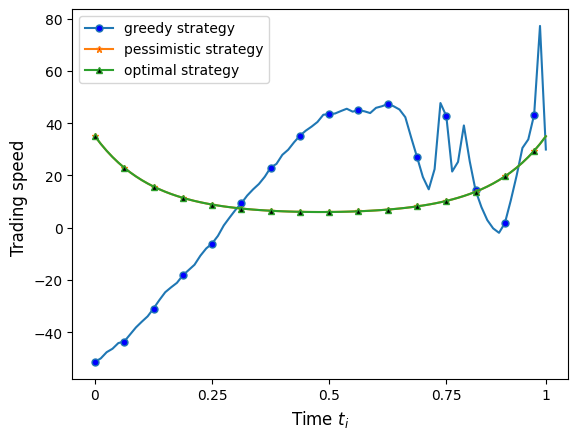

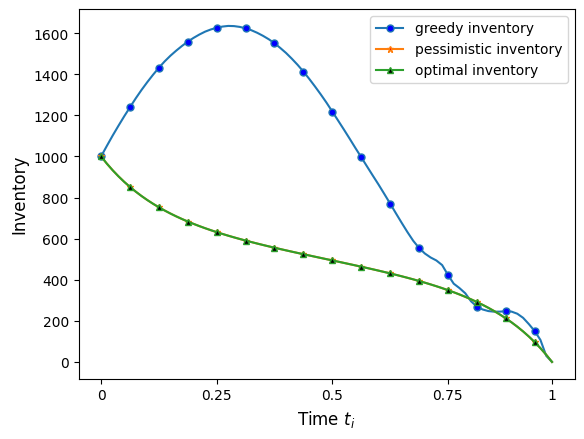

In [ ]:
#plot results

print(true_val_fun)
print(val_fun_reg)
print(val_fun_greedy)

plt.plot(greedy_policy,marker='o', markerfacecolor='blue',markevery=5,markersize=5,label="greedy strategy")
plt.plot(pessimistic_policy,marker='*', markerfacecolor='red',markevery=5,markersize=5,label="pessimistic strategy")
plt.plot(policy_analytic,marker='^', markerfacecolor='black',markevery=5,markersize=5,label="optimal strategy")

plt.xlabel("Time $t_i$",fontsize=12)
plt.ylabel("Trading speed ",fontsize=12)
positions = (0, 20, 40, 60, 77)
labels = ("0","0.25", "0.5", "0.75", "1")
plt.xticks(positions, labels)
plt.legend()
plt.show()

plt.plot(inventory_greedy,marker='o', markerfacecolor='blue',markevery=5,markersize=5,label="greedy inventory")
plt.plot(inventory_pessimistic,marker='*', markerfacecolor='red',markevery=5,markersize=5,label="pessimistic inventory")
plt.plot(inventory_analytic,marker='^', markerfacecolor='black',markevery=5,markersize=5,label="optimal inventory")

plt.xlabel("Time $t_i$",fontsize=12)
plt.ylabel("Inventory",fontsize=12)
positions = (0, 20, 40, 60, 78)
labels = ("0","0.25", "0.5", "0.75", "1")
plt.xticks(positions, labels)
plt.legend()
plt.show()